## Compute LAVI

- The use of the longer LA length between the apical two- and four-chamber views is recommended.
- LA volumes should be measured from the apical four- and two-chamber views.
- The most commonly used method for 2D echocardiographic volume calculations is the biplane method of disks summation (modified Simpson’s rule), which is the recommended 2D echocardiographic method by consensus of this committee
- Note: Two-dimensional echocardiographic image acquisition should aim to maximize LA area

- Measurements and feature names:
    - LAVI - Left atrium end diastolic volume indexed to BSA

- LA size and volume measurements should be reported indexed to BSA. For general reference, 2D echocardiographic 
    - LA volume of 35 mL/m<sup>2</sup> should be used as the upper limit of the corresponding normal range.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from scipy.stats import mannwhitneyu
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

from utils import util_measurement, stats_and_plots, measurements_dict, BA_plot

In [2]:
def get_dataCat(df,feature1, value):
    """
    transform feature value in categorical
    Input: 
        - dataframe 
        - feature to be categorized. E.g., LAVI_echo_cat, LAV_echo, LAV_model LVMI_echo_cat, LVEF_echo, etc.
        - value to use as normal - Use 0 for RAVI, and RV, 35 for LVEF, normal for others
    """

    df_BA = df.copy()
    if feature1 == 'LVEF_echo':
        df_BA[feature1][df_BA[feature1] > value] = 'Normal' 
    else:
        df_BA[feature1][df_BA[feature1] == value] = 'Normal' 

    df_BA[feature1][df_BA[feature1] != 'Normal'] = 'Abnormal'
    return df_BA[feature1]

## Load Numbers table

In [3]:
### Load Clinical Echo Measurements

df_numbers = pd.read_csv('test_data/LA_volumetrics/LA_volumetrics.csv')
df_numbers = df_numbers[['anonid', 'Pt. Sex', 'BSA', 'LAVI_echo']]

## Load dataframes with LV measurements - A2C, A4C views

In [4]:
df_a2c_allFrames = pd.read_csv('test_data/LA_volumetrics/A2C_measures_R2.csv')
df_a2c_allFrames.describe()

,RR,bbox-0,bbox-1,bbox-2,bbox-3,area,filled_area,convex_area,centroid-0,centroid-1,...,y_top,L_disk,Rsquared,RMSE,MSE,cycles,freq,amplitude,phase,offset
count,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,37.400000,92.700000,96.800000,169.05000,164.850000,21.029663,21.029663,24.044495,131.600000,130.900000,...,125.350000,0.279903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,23.665209,42.959099,17.733703,44.37813,21.646137,9.585444,9.585444,11.840463,40.337262,15.630268,...,19.738488,0.098979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,14.000000,29.000000,69.000000,80.00000,132.000000,0.805664,0.805664,0.921631,74.000000,114.000000,...,100.000000,0.035293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,22.000000,53.000000,89.750000,146.25000,148.750000,17.785645,17.785645,18.865967,99.500000,120.750000,...,111.500000,0.239232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,26.500000,82.000000,95.000000,165.00000,167.000000,22.406006,22.406006,23.712158,118.500000,128.500000,...,120.000000,0.295099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,60.000000,137.000000,106.000000,204.00000,174.750000,25.340271,25.340271,29.846191,171.750000,138.750000,...,140.250000,0.338303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,89.000000,155.000000,148.000000,238.00000,225.000000,36.083984,36.083984,46.630859,192.000000,184.000000,...,170.000000,0.408972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_a4c_allFrames = pd.read_csv('test_data/LA_volumetrics/A4C_measures_R2.csv')
df_a4c_allFrames.describe()

,RR,bbox-0,bbox-1,bbox-2,bbox-3,area,filled_area,convex_area,centroid-0,centroid-1,...,y_top,L_disk,Rsquared,RMSE,MSE,cycles,freq,amplitude,phase,offset
count,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.000000,40.000000,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
mean,35.900000,97.175000,89.775000,172.775000,139.825000,16.035004,16.035004,17.319336,135.925000,113.575000,...,112.700000,0.278332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,19.408959,41.501861,22.925171,39.555535,31.188334,6.994228,6.994228,7.589629,36.318666,26.098322,...,30.657914,0.083439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,22.000000,44.000000,57.000000,94.000000,94.000000,2.465820,2.465820,2.905273,82.000000,71.000000,...,66.000000,0.063244,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,24.000000,58.500000,69.500000,146.000000,108.000000,12.831116,12.831116,13.558960,106.000000,88.750000,...,87.500000,0.238376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,27.000000,88.000000,88.000000,158.500000,141.500000,15.341187,15.341187,16.461182,125.000000,112.500000,...,106.000000,0.296929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,45.000000,142.000000,110.500000,207.250000,165.250000,20.001221,20.001221,20.903015,174.000000,135.750000,...,142.250000,0.346939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,87.000000,154.000000,134.000000,237.000000,193.000000,31.835938,31.835938,34.216309,192.000000,154.000000,...,175.000000,0.401182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Apply qc rules

In [6]:
# Take the left atrial labels
df_a2c_LA = df_a2c_allFrames.query('label == "LA"')
df_a4c_LA = df_a4c_allFrames.query('label == "LA"')

# Only keep the clips with the best fit to the sinusoidal model
df_a2c_LA = df_a2c_LA.sort_values(by='Rsquared', ascending=False).drop_duplicates('anonid')
df_a4c_LA = df_a4c_LA.sort_values(by='Rsquared', ascending=False).drop_duplicates('anonid')

# Take the frames that maximize the LA area
df_a2c = df_a2c_LA.sort_values(by='area', ascending=False).drop_duplicates('ID_clip')
df_a4c = df_a4c_LA.sort_values(by='area', ascending=False).drop_duplicates('ID_clip')

print('Final A2C frames:',df_a2c.shape[0], len(df_a2c.anonid.unique()))
print('Final A4C frames:',df_a4c.shape[0], len(df_a4c.anonid.unique()))

Final A2C frames: 10 10
Final A4C frames: 10 10


## Merge Data

In [7]:
# Merge A2C and A4C dataframes
df_all = df_a2c.merge(df_a4c, on = ["anonid"],suffixes=("_a2c","_a4c"))

# Merge with clinical data
df_all = df_all.merge(df_numbers,on=['anonid'],how='left')

print(f'a2c size:{df_a2c.shape[0]}, a2c anonid:{len(df_a2c.anonid.unique())}, a4c size:{df_a4c.shape[0]}, anonid:{len(df_a4c.anonid.unique())}, merged:{df_all.shape[0]}, merged anonid:{len(df_all.anonid.unique())}')

a2c size:10, a2c anonid:10, a4c size:10, anonid:10, merged:10, merged anonid:10


## Compute LAVI

In [8]:
# Calculate the LAVI
df_vol = util_measurement.get_volumetrics(df_all, metric='LAVI')
print(df_vol.shape[0],len(df_vol.ID_clip_a2c.unique()),len(df_vol.ID_clip_a4c.unique()))

  0%|          | 0/10 [00:00<?, ?it/s]/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 10/10 [00:00<00:00, 1308.27it/s]

10 10 10


## Bin LA Volume into Normal and Abnormal

In [9]:
# Filter out studies with missing values
df_vol = df_vol[(df_vol['Pt. Sex'] == 'F') | (df_vol['Pt. Sex'] == 'M')]

## Cat values for Model Pred
df_vol['LAVI_model_cat'] = df_vol['LAVI_model'].astype(int)
df_vol['LAVI_model_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['LAVI_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lavi_echo_male_dict)), df_vol['LAVI_model_cat'])
df_vol['LAVI_model_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['LAVI_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lavi_echo_female_dict)), df_vol['LAVI_model_cat'])

## Cat values for Numbers table 
df_vol['LAVI_echo_cat'] = df_vol['LAVI_echo'].astype(int)
df_vol['LAVI_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['LAVI_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lavi_echo_male_dict)), df_vol['LAVI_echo_cat'])
df_vol['LAVI_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['LAVI_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lavi_echo_female_dict)), df_vol['LAVI_echo_cat'])
df_vol = df_vol[(df_vol['Pt. Sex'] == 'F') | (df_vol['Pt. Sex'] == 'M')]

## Compute and plot some metrics

Volume - Left Atrium 
(10, 81)


,LAVI_echo,LAVI_model
mean,28.863060,36.625364
std,11.828402,14.574840
min,18.617778,17.905879
max,53.322059,58.399614


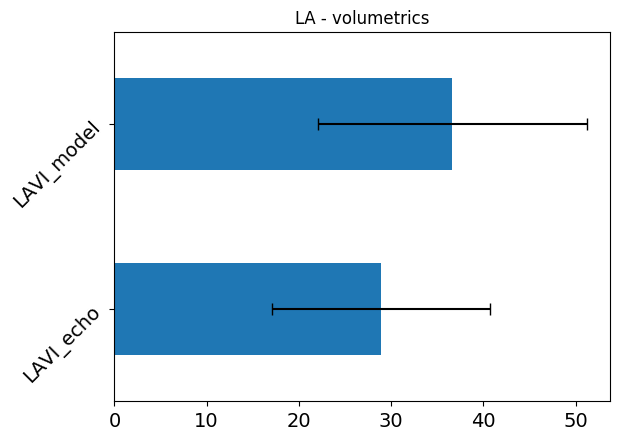

In [10]:
## Mean, std and range of volume.
print('Volume - Left Atrium ')
print(df_vol.shape)
df_vol_stats  = df_vol[['LAVI_echo', 'LAVI_model']].agg(['mean','std','min', 'max'])
display(df_vol_stats)


df_vol_stats.T.plot(kind = "barh", y = ["mean"], legend = False,
            title = 'LA - volumetrics',fontsize=14,  xerr='std', capsize=4,rot=45)
plt.show()

## Regression and Bland-Altman Plots


10


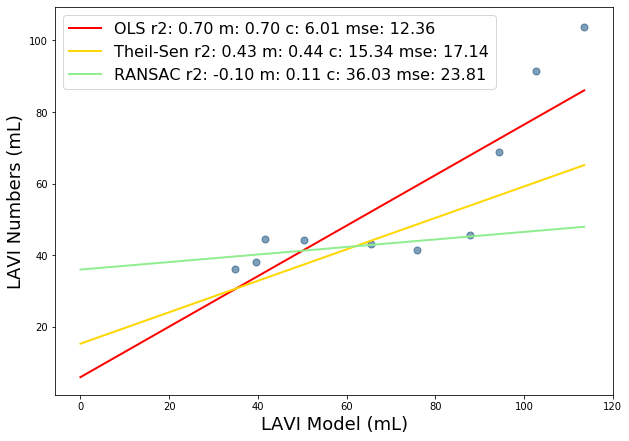

['Normal', 'Abnormal']
['Abnormal' 'Normal']


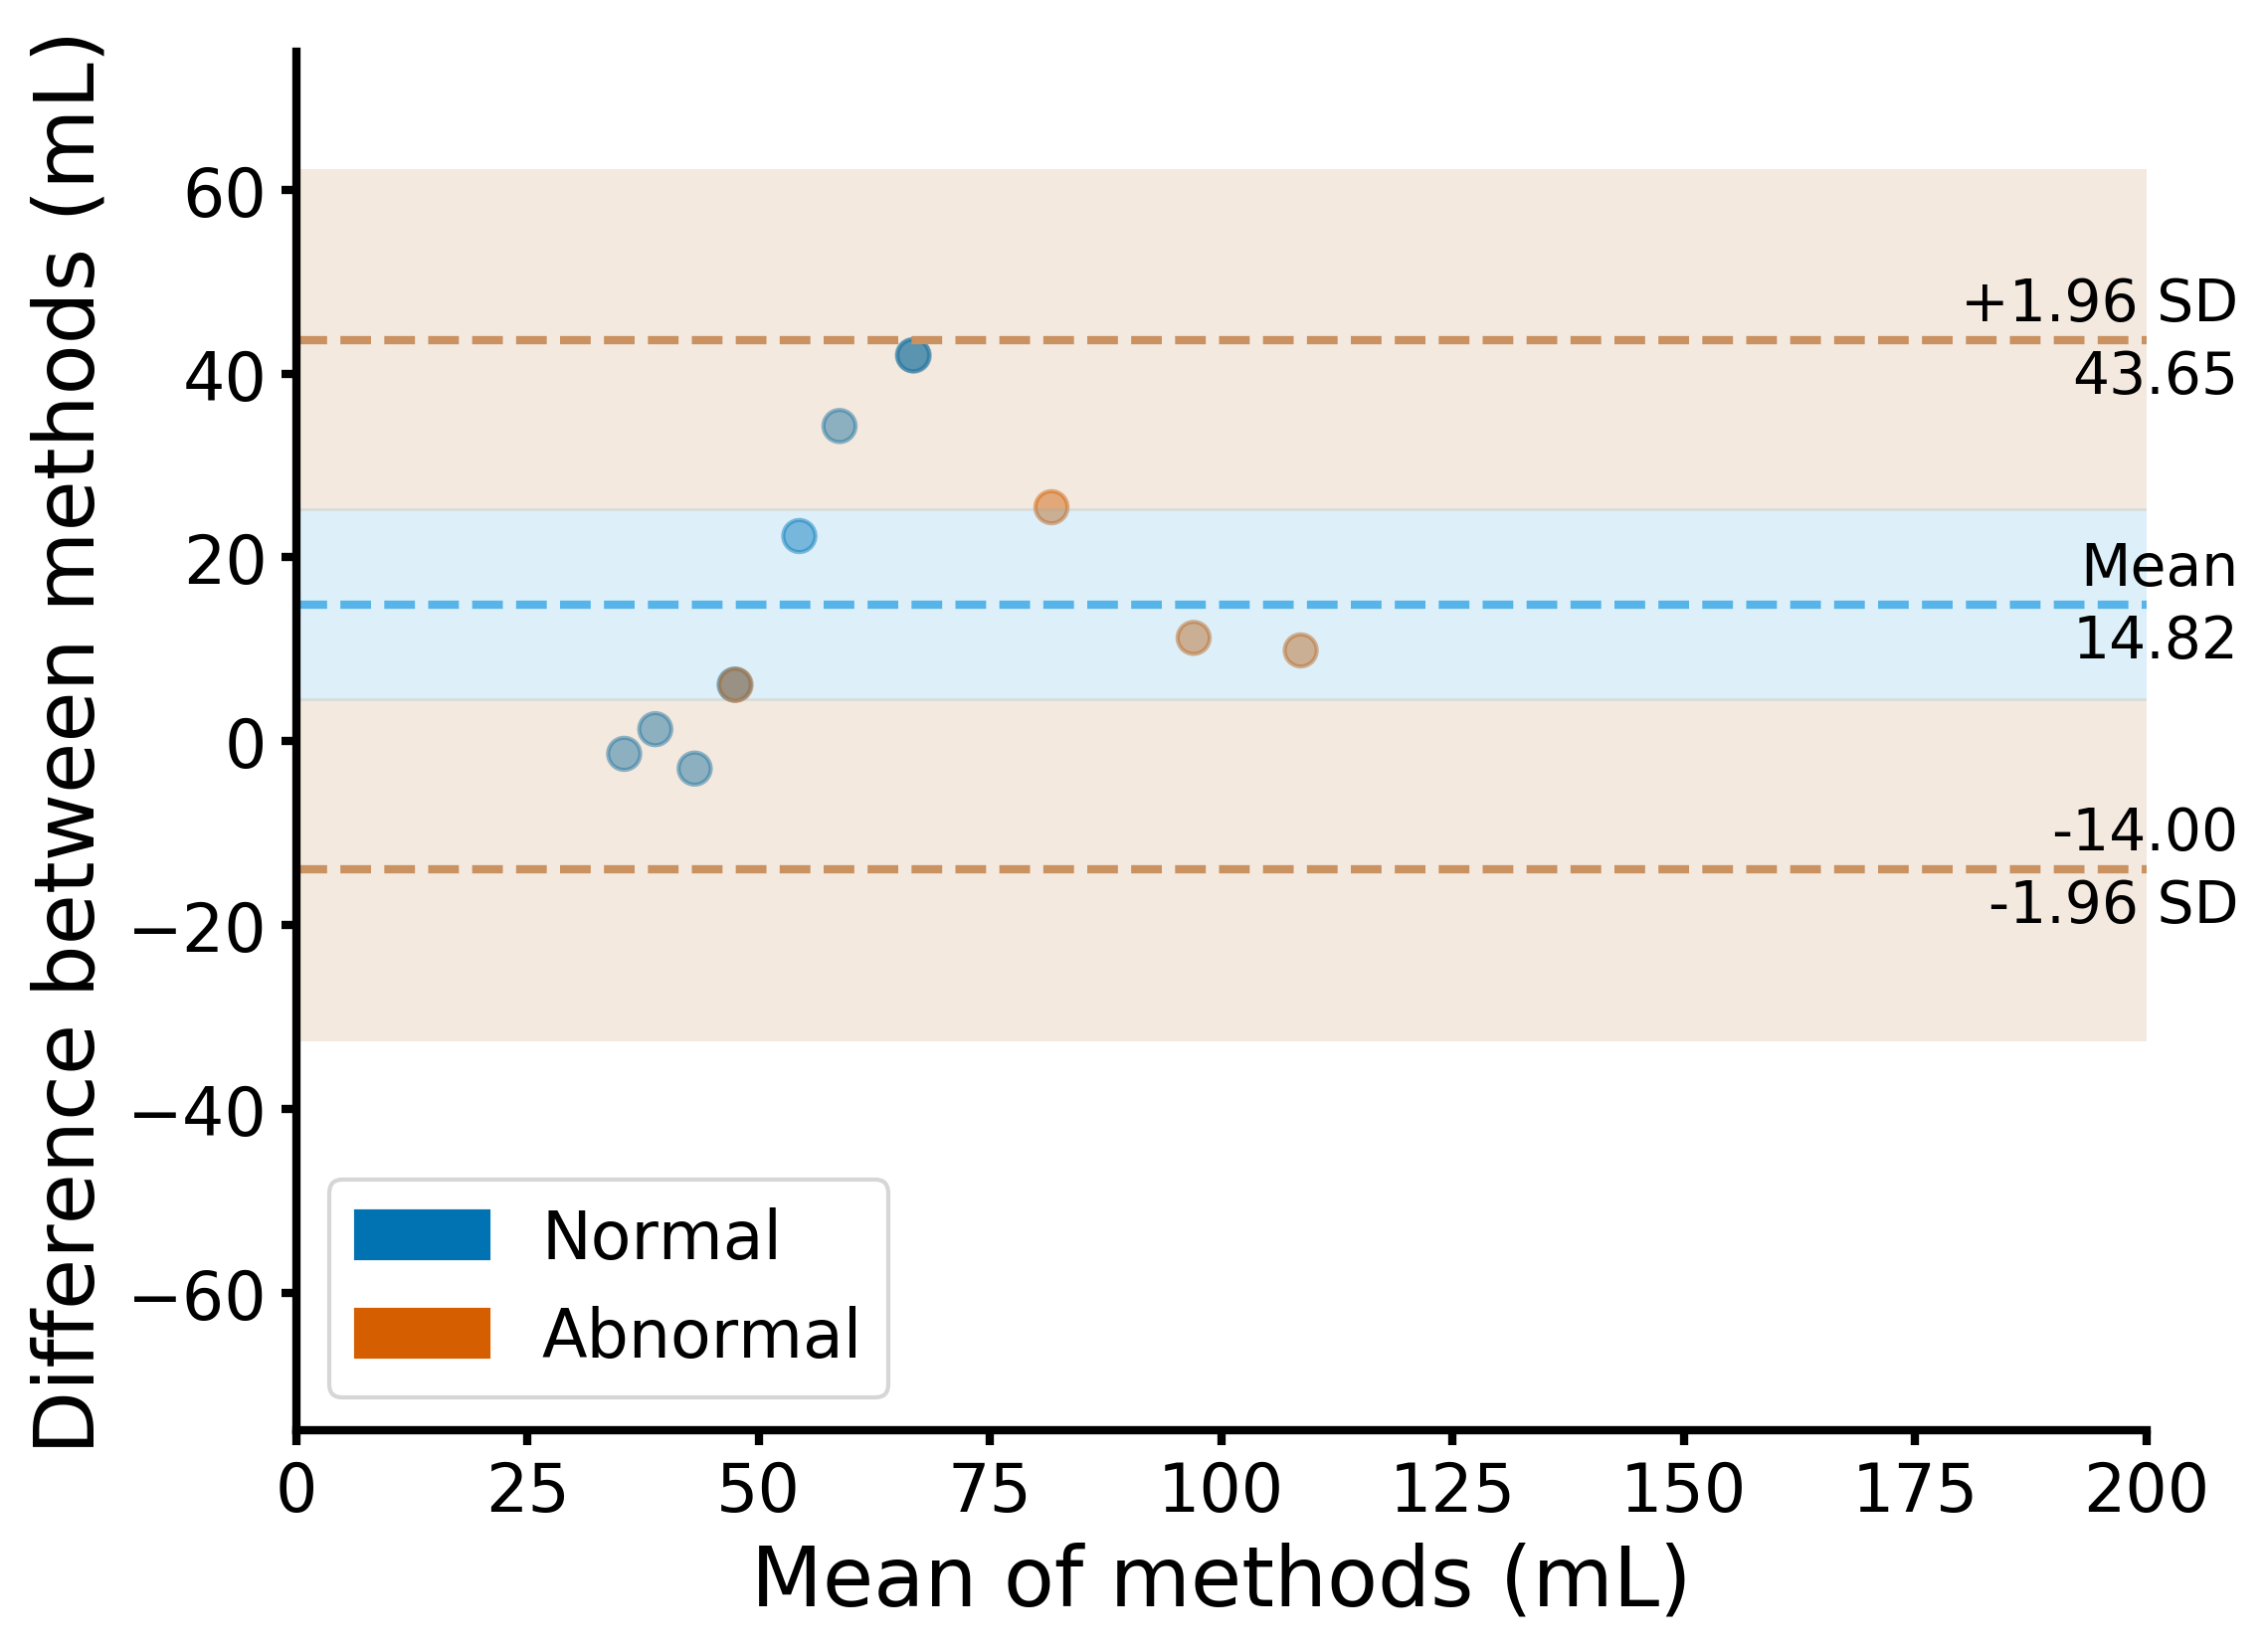

SpearmanrResult(correlation=0.8787878787878788, pvalue=0.0008138621117322101)
MWU p-value: MannwhitneyuResult(statistic=38.0, pvalue=0.19233653136775436)


/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [11]:
############ LAVI ##################

df_plot = df_vol

ys = df_plot['LAVI_echo'] * df_plot['BSA']
xs = df_plot['LAVI_model'] * df_plot['BSA']
print(len(xs))
stats_and_plots.get_reg_plot(xs,ys,'Numbers-Model','LAVI Model','LAVI Numbers','mL')

dataCat = df_plot.LAVI_echo_cat
BA_plot.blandAltman(xs, ys,dataCat,percentage=False, figureSize=((8,6)),meanColour='#56b4e9', dpi = 300,
                    loaColour='#ca9161', pointColour='#0173b2',lim_inf=-75, lim_sup=75, lim_inf_x=0,
                    lim_sup_x=200, cat=True, unity='mL')

plt.show()
print(scipy.stats.spearmanr(xs,ys))
scipy.stats.normaltest(xs-ys) # (if P < 0.05 then reject normality).
print('MWU p-value:',mannwhitneyu(xs,ys))

## Plot Confusion Matrix

Confusion Matrix - Numbers vs Unet


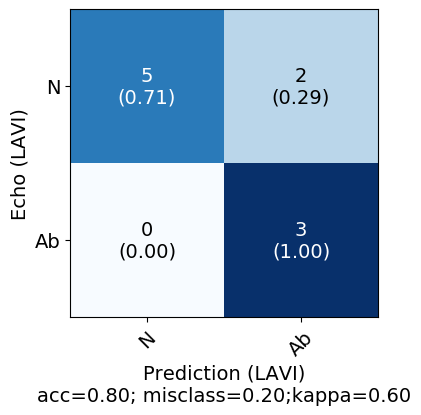

In [12]:
############### LAVI ##################

plt.rcParams.update({'font.size': 14})


y_true = df_vol['LAVI_echo_cat'] == 'Abnormal'
y_pred = df_vol['LAVI_model_cat'] == 'Abnormal'

cm = confusion_matrix(y_true, y_pred) #.ravel()

accuracy = np.trace(cm) / np.sum(cm).astype('float')   ## total samples that were correctly classified
misclass = 1 - accuracy
k = cohen_kappa_score(y_true.astype(int), y_pred.astype(int))

plot_confusion_matrix(conf_mat=cm,colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=['N','Ab'],
                                figsize=(4, 4))
plt.ylabel('Echo (LAVI)')
plt.xlabel('Prediction (LAVI)\nacc={:0.2f}; misclass={:0.2f};kappa={:0.2f}'.format(accuracy, misclass,k))
print('Confusion Matrix - Numbers vs Unet')
plt.show()